In [1]:
import numpy as np
import pandas as pd
from os import path

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# DATA_HOME = '/home/chandan047/psu/self_disclosure/claff-offmychest/data/'

In [3]:
# TRAIN_HOME      = path.join(DATA_HOME, 'training data')
# TEST_HOME       = path.join(DATA_HOME, 'test data')
# UNLABELED_HOME  = path.join(DATA_HOME, 'unlabeled data')

# train_set_df        = pd.read_csv(path.join(TRAIN_HOME, "labeled_training_set.csv"))
# test_set_df         = pd.read_csv(path.join(TEST_HOME, "unlabeled_test_set.csv"))
# posts_traintest_df  = pd.read_csv(path.join(UNLABELED_HOME, "posts_trainingandtest_fullsent.csv"))
# posts_test_df       = pd.read_csv(path.join(UNLABELED_HOME, "posts_unlabeled_fullsent.csv"))
# comments_score_df   = pd.read_csv(path.join(UNLABELED_HOME, "comments_score_unlabeled.csv"))

In [4]:
forest_df = pd.read_csv('forest.csv')

In [5]:
forest_df.columns

Index(['Unnamed: 0', 'commentid', 'treeid', 'authors', 'created_utc', 'score',
       'wordcount', 'full_text', 'parent', 'postid', 'Emotional_disclosure',
       'Emotional_disclosure_sentid', 'Information_disclosure',
       'Information_disclosure_sentid', 'Support', 'Support_sentid',
       'General_support', 'General_support_sentid', 'Info_support',
       'Info_support_sentid', 'Emo_support', 'Emo_support_sentid'],
      dtype='object')

In [6]:
Labels = ['Emotional_disclosure', 'Emotional_disclosure_sentid', 
          'Information_disclosure', 'Information_disclosure_sentid', 
          'Support', 'Support_sentid',
          'General_support', 'General_support_sentid', 
          'Info_support', 'Info_support_sentid', 
          'Emo_support', 'Emo_support_sentid']

In [7]:
forest_df = forest_df.dropna()
forest_df.head()

,Unnamed: 0,commentid,treeid,authors,created_utc,score,wordcount,full_text,parent,postid,...,Information_disclosure,Information_disclosure_sentid,Support,Support_sentid,General_support,General_support_sentid,Info_support,Info_support_sentid,Emo_support,Emo_support_sentid
0,0,1,1000001,stinkbugsinfest,1532508063,1902,30,You are quite the writer and have a deep sense...,-1,91px39,...,-1,[],-1,[],-1,[],-1,[],-1,[]
1,1,2,1000001,Stimonk,1532516303,507,20,"Yeah, you might want to share that story with ...",1,91px39,...,-1,[],-1,[],-1,[],-1,[],-1,[]
3,3,4,1000001,hanxperc,1532536955,85,32,"awww, forcing to hug when you argue. that's ad...",3,91px39,...,-1,[],-1,[],-1,[],-1,[],-1,[]
5,5,6,1000001,shhh14,1532652115,36,60,"Okay this is goddamn adorable, and so was this...",5,91px39,...,-1,[],-1,[],-1,[],-1,[],-1,[]
6,6,7,1000001,LeniaLilac,1532518450,79,29,Agree! Get two nice notebooks and write it dow...,2,91px39,...,0,[36.0],0,[36.0],0,[36.0],0,[36.0],0,[36.0]


In [8]:
class Tree():
    def __init__(self, id, created_utc, author):
        self.id = id
        self.created_utc = created_utc
        self.author = author


class Post(Tree):
    def __init__(self, id, created_utc, author):
        Tree.__init__(self, id, created_utc, author)
        self.topcomments = None
        self.map_id2index = None
        self.depth = 0
        self.size = 0
        
        self.partial = False
    
    def n_topcomments(self):
        if self.topcomments == None:
            return 0
        return len(self.topcomments)
    
    def add_comment(self, comment):
        if comment.labels[0] != -1:
            self.partial = True
        if self.map_id2index is None:
            self.map_id2index = {}
        
        if self.topcomments is None:
            self.topcomments = []
        
        if comment.id in self.map_id2index:
            print ("Comment {} already added".format(comment.id))
            return False
        
        if comment.parent == -1:
            self.map_id2index[comment.id] = self.n_topcomments()
            self.topcomments.append(comment)
            self.depth = max(self.depth, comment.depth)
            self.size += 1
            return True
        
        for top in self.topcomments:
            if top.add_reply(comment):
                self.depth = max(self.depth, top.depth)
                self.size += 1
                return True
        
        return False


class Comment(Tree):
    def __init__(self, id, postid, created_utc, author, score, full_text, wordcount, parent, labels):
        Tree.__init__(self, id, created_utc, author)
        self.postid = postid
        self.replies = None
        self.map_id2index = None
        self.parent = parent
        self.score = score
        self.full_text = full_text
        self.wordcount = wordcount
        self.labels = labels
        
        self.depth = 1
        self.size = 1
        
    def is_labeled(self):
        return self.labels[0] != -1
    
    def n_direct_replies(self):
        if self.replies == None:
            return 0
        return len(self.replies)
    
    def add_reply(self, reply):
        if self.id != reply.parent and self.replies is None:
            return False
        
        if self.map_id2index is None:
            self.map_id2index = {}
        
        if self.replies is None:
            self.replies = []
        
        if reply.id in self.map_id2index:
            print ("Direct reply {} already added".format(reply.id))
            return False
        
        if self.id != reply.parent:
            for r in self.replies:
                if r.add_reply(reply):
                    self.depth = max(self.depth, r.depth + 1)
                    self.size += 1
                    return True
            return False
        else:
            self.map_id2index[reply.id] = self.n_direct_replies()
            self.replies.append(reply)
            return True

In [9]:
def buildPosts(df):
    posts = []
    map_id2index = {}
    
    comments = []
    
    failures = 0
    
    for _, row in df.iterrows():
        # check if this post exists
        index = None
        postid = row['postid']
        if postid in map_id2index:
            index = map_id2index[postid]
        else:
            index = len(posts)
            posts.append(Post(postid, None, None))
            map_id2index[postid] = index
    
        # add comment to the post
        comment = Comment(row['commentid'], row['postid'], row['created_utc'], row['authors'], 
                          row['score'], row['full_text'], row['wordcount'], row['parent'], 
                          [row[l] for l in Labels])
    
        if posts[index].add_comment(comment):
            comments.append(comment)
        else:
            failures += 1
    
    print ('failures', failures)
    print ('total comments', forest_df.shape)
    
    return posts, comments

In [10]:
posts, comments = buildPosts(forest_df)

failures 17270
total comments (130244, 22)


# Dataset preparation

In [11]:
N_COMMS = 12

In [12]:
prefix1 = "Commentid"
prefix2 = "text"

columns = []
for i in range(N_COMMS):
    columns.append(prefix1 + str(i+1))
    columns.append(prefix2 + str(i+1))

dataset = pd.DataFrame(columns=columns)

In [13]:
dataset.head()

,Commentid1,text1,Commentid2,text2,Commentid3,text3,Commentid4,text4,Commentid5,text5,...,Commentid8,text8,Commentid9,text9,Commentid10,text10,Commentid11,text11,Commentid12,text12


### We need 12 comments per line

## Partially labeled direct reply comments

We take around 15 direct reply comments with atleast 12 legnth

In [14]:
partial = np.zeros(len(comments))

for index, comment in enumerate(comments):
    if comment.is_labeled():
        partial[index] = 1
    elif comment.replies != None:
        if any([r.is_labeled() for r in comment.replies]):
            partial[index] = 1

In [15]:
partial_comments = [comment for index, comment in enumerate(comments) if partial[index] == 1]

In [16]:
pcomm_sizes = [1 + pcomm.n_direct_replies() for pcomm in partial_comments]
big_pcomm_inds = [index for index, sz in enumerate(pcomm_sizes) if sz >= 12]
big_pcomm_sizes = [pcomm_sizes[index] for index in big_pcomm_inds]
print ("Direct reply comments", len(big_pcomm_sizes))

Direct reply comments 16


In [17]:
big_pcomm_inds?

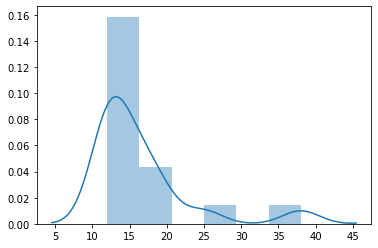

In [18]:
ax = sns.distplot(big_pcomm_sizes)

In [19]:
DATAID1 = []

def add_DATA1(N = 15):
    partial_comments = [comment for index, comment in enumerate(comments) if partial[index] == 1]
    pcomm_sizes = [1 + pcomm.n_direct_replies() for pcomm in partial_comments]
    big_pcomm_inds = [index for index, sz in enumerate(pcomm_sizes) if sz >= 12]
    
    dataset = pd.DataFrame(columns=columns)
    
    for index, ind in enumerate(big_pcomm_inds):
        if index >= N:
            break
        
        parent = partial_comments[ind]
        DATAID1.append(parent.id)
        
        # TODO : change to comment full_text
        data = [parent.id, parent.full_text]
        # data = [parent.id, ""]
        
        assert(parent.n_direct_replies() >= N_COMMS - 1)
        
        for j, child in enumerate(parent.replies):
            if j >= N_COMMS - 1:
                break
            
            DATAID1.append(child.id)
            data.append(child.id)
            data.append(child.full_text)
            # data.append("")
        
        data = {col:[dat] for col, dat in zip(columns, data)}
        dataset = dataset.append(pd.DataFrame(data))
    
    return dataset

In [20]:
df = add_DATA1()
print (df.shape)
dataset = dataset.append(df)

(15, 24)


## Partially labeled posts with atleast 12 aggregate comments

We take first 12 comments (both direct and in-direct) from 185 posts 

In [21]:
partial_posts = [post for post in posts if post.partial]
big_partial_inds = [index for index, partial in enumerate(partial_posts) if partial.size >= 12]
big_partial_sizes = [partial_posts[index].size for index in big_partial_inds]
print ("Aggregate comments", len(big_partial_inds))

Aggregate comments 1423


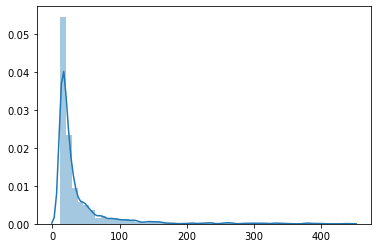

In [22]:
ax = sns.distplot(big_partial_sizes)

In [23]:
DATAID2 = []

def add_DATA2(N = 185):
    partial_posts = [post for post in posts if post.partial]
    big_partial_inds = [index for index, partial in enumerate(partial_posts) if partial.size >= 12]
    
    dataset = pd.DataFrame(columns=columns)
    
    all_ids = forest_df['postid'].values.tolist()
    
    for index, ind in enumerate(big_partial_inds):
        if index >= N:
            break
        
        # TODO : change to comment full_text
        # data = [parent.id, parent.full_text]
        data = []
        
        postid = partial_posts[ind].id
        
        start_ind = next(i for i, pid in enumerate(all_ids) if pid == postid)
        for j in range(N_COMMS):
            data.append(forest_df.iloc[start_ind]['commentid'])
            data.append(forest_df.iloc[start_ind]['full_text'])
            # data.append("")
            start_ind += 1
        
        data = {col:[dat] for col, dat in zip(columns, data)}
        dataset = dataset.append(pd.DataFrame(data))
    
    return dataset

In [24]:
df = add_DATA2()
dataset = dataset.append(df)

In [25]:
dataset?

In [26]:
dataset.to_csv("dataset.csv")